In [37]:
# Import libraries
import pandas as pd
import numpy as np
import lightgbm as lgb
import fasttext as ft

from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

from utilities import data_basic_utility as databasic
from utilities import dataframe_utility as dfutil
from utilities import regex_utility as reutil
import features_utility as featutil

import nltk

## File Details - Light GBM Regression NLP on Beer Text

First look at NLP on the Text. Probably need to look at the Lemmatized column, possibly filter on the POS.
But first run, will literally just feed in Lemmatized, see what happens

Characteristics:
* Light GBM Regression Algorithm
* Start working on NLP on the Beer text columns


In [38]:
filePrefix = "A3_123_lgbm_nlp_beertext"
baseDataDir = "C:/Development/Data/COSC2670/Assignment3/A3data/"
subrunDir = "subruns/"
featuresDataDir = "features/"
modelsDir = "models/"
writeSubRunFile = True
seed = databasic.get_random_seed()

In [39]:
trainFilePath = baseDataDir + 'train.tsv'
valiFilePath = baseDataDir + 'val.tsv'
featuresFilePath = baseDataDir + 'features.tsv'
testFilePath = baseDataDir + 'test.tsv'

# trainFilePath = baseDataDir + 'train_200k.tsv'
# valiFilePath = baseDataDir + 'vali_200k.tsv'
# featuresFilePath = baseDataDir + 'features_200k.tsv'
# testFilePath = baseDataDir + 'test_200k.tsv'

In [40]:
df_train = pd.read_csv(trainFilePath, sep='\t',
                         names=['RowID','BeerID','ReviewerID',
                                  'BeerName','BeerType','rating'])

df_vali = pd.read_csv(valiFilePath, sep='\t',
                         names=['RowID','BeerID','ReviewerID',
                                  'BeerName','BeerType','rating'])


df_test = pd.read_csv(testFilePath, sep='\t',
                         names=['RowID','BeerID','ReviewerID',
                                  'BeerName','BeerType','rating'])                                

print(df_train.shape)

(845008, 6)


In [41]:
# # RowID BrewerID ABV DayofWeek Month DayofMonth Year TimeOfDay Gender Birthday Text Lemmatized POS_Tag
# # df_features = pd.read_csv(baseDataDir + 'features_500k.tsv',sep='\t', names=['RowID','BrewerID','ABV','DayofWeek','Month',
df_features = pd.read_csv(featuresFilePath,sep='\t', names=['RowID','BrewerID','ABV','DayofWeek','Month',
                                                                 'DayofMonth','Year','TimeOfDay','Gender',
                                                                 'Birthday','Text','Lemmatized','POS_Tag'])

df_features.head()

colsToUse = ["Text", "Lemmatized", "POS_Tag"]

# Find the feature records that match the training and validation data and join them together
dfFullData = df_train.join(df_features[colsToUse], on="RowID", how="inner", rsuffix="Feat")
dfFullDataVali = df_vali.join(df_features[colsToUse], on="RowID", how="inner", rsuffix="Feat")
dfFullDataTest = df_test.join(df_features[colsToUse], on="RowID", how="inner", rsuffix="Feat")

dfFullData.head()

# Remove the duplicated Row ID, also remove Beer Name at this point, we're nt using it
# df_train_data = dfFullData.drop(['RowIDFeat', "BeerName"],axis=1)
# df_vali_data = dfFullDataVali.drop(['RowIDFeat', "BeerName"],axis=1)
df_train_data = dfFullData.drop(["BeerName", "BeerType", "Text", "POS_Tag"],axis=1)
df_vali_data = dfFullDataVali.drop(["BeerName", "BeerType", "Text", "POS_Tag"],axis=1)
df_test_data = dfFullDataTest.drop(["BeerName", "BeerType", "Text", "POS_Tag"],axis=1)

df_train_data.head()

,RowID,BeerID,ReviewerID,rating,Lemmatized
0,19,12300,10635,4.0,"`` warning , this beer have a intense smoke fl..."
1,21,12300,6547,4.5,Amber brown in color with very little head but...
2,23,12300,9789,4.5,"complex enjoyable smoke . tasty rich malt , ca..."
3,24,12300,7372,5.0,"this beer pour a dark amber color , with a per..."
4,25,12300,1302,4.5,pour a rich burn caramel hue with some deep am...


Let's just look at Beer name first. Compile a full list of the beer names, save it to file with one per line. Then we can load it with fasttext and build a language model

In [42]:
colName = "Lemmatized"
df_train_data, df_vali_data, df_test_data, documentFilePath = featutil.formatTextColForNLP(df_train_data, df_vali_data, df_test_data, colName, featuresDataDir, filePrefix, 50, 50)

[(('white', 'head'), 187708), (('pint', 'glass'), 100476), (('tan', 'head'), 92481), (('roasted', 'malt'), 88686), (('sweet', 'malt'), 68522), (('beer', 'pour'), 68030), (('medium', 'bodied'), 65921), (('dark', 'fruit'), 64061), (('dark', 'brown'), 63176), (('caramel', 'malt'), 59383), (('oz', 'bottle'), 56665), (('bottle', 'pour'), 56355), (('pour', 'dark'), 53924), (('medium', 'body'), 53081), (('amber', 'color'), 48840), (('taste', 'like'), 47578), (('12', 'oz'), 47421), (('hop', 'bitterness'), 46757), (('hop', 'flavor'), 46154), (('little', 'bit'), 45559), (('offwhite', 'head'), 43105), (('good', 'beer'), 42585), (('lacing', 'smell'), 40439), (('head', 'smell'), 39794), (('smell', 'like'), 39786), (('pour', 'clear'), 39326), (('pretty', 'good'), 38725), (('head', 'leave'), 38704), (('easy', 'drink'), 38585), (('brown', 'sugar'), 38294), (('12oz', 'bottle'), 38053), (('pale', 'ale'), 37200), (('dark', 'chocolate'), 36267), (('malt', 'flavor'), 35561), (('finger', 'head'), 35029), ((

Most Frequent Words and Bigrams:
[('beer', 174641), ('hop', 144586), ('head', 136003), ('taste', 115450), ('malt', 114879), ('pour', 113880), ('nice', 96037), ('flavor', 94335), ('good', 86343), ('like', 75634), ('smell', 75215), ('light', 73257), ('aroma', 72055), ('sweet', 70629), ('one', 70319), ('bit', 64462), ('bottle', 64312), ('finish', 62183), ('dark', 60571), ('glass', 59983), ('carbonation', 58731), ('color', 57863), ('well', 56893), ('little', 52933), ('mouthfeel', 47370), ('would', 45244), ('chocolate', 45155), ('lacing', 44635), ('note', 42172), ('really', 42148), ('brown', 41158), ('alcohol', 39851), ('caramel', 39761), ('body', 39751), ('great', 38695), ('much', 38127), ('get', 37967), ('white', 37964), ('medium', 37656), ('nose', 36845), ('bitter', 36704), ('citrus', 36594), ('bitterness', 36504), ('coffee', 34664), ('drink', 34411), ('leave', 33541), ('smooth', 33516), ('brew', 33311), ('hint', 32242), ('pretty', 30249)]

[(('white', 'head'), 26219), (('pint', 'glass'), 15662), (('roasted', 'malt'), 13588), (('tan', 'head'), 13566), (('sweet', 'malt'), 10066), (('medium', 'bodied'), 9855), (('beer', 'pour'), 9270), (('caramel', 'malt'), 9250), (('dark', 'brown'), 9016), (('bottle', 'pour'), 8550), (('dark', 'fruit'), 8504), (('oz', 'bottle'), 8069), (('medium', 'body'), 8026), (('hop', 'flavor'), 8002), (('pour', 'dark'), 7601), (('hop', 'bitterness'), 7299), (('amber', 'color'), 7210), (('12', 'oz'), 6761), (('dark', 'chocolate'), 6717), (('pale', 'ale'), 6651), (('little', 'bit'), 6595), (('taste', 'like'), 6426), (('offwhite', 'head'), 6300), (('citrus', 'hop'), 6226), (('head', 'leave'), 6019), (('smell', 'like'), 6018), (('lacing', 'smell'), 5995), (('good', 'beer'), 5940), (('pour', 'clear'), 5806), (('12oz', 'bottle'), 5711), (('brown', 'sugar'), 5456), (('pretty', 'good'), 5415), (('head', 'smell'), 5367), (('easy', 'drink'), 5357), (('well', 'balanced'), 5290), (('floral', 'hop'), 5268), (('finger', 'head'), 5252), (('glass', 'pour'), 5189), (('hop', 'aroma'), 5162), (('malt', 'flavor'), 5054), (('sierra', 'nevada'), 4776), (('dry', 'finish'), 4737), (('pour', 'deep'), 4656), (('full', 'bodied'), 4652), (('brown', 'head'), 4525), (('golden', 'color'), 4509), (('brown', 'color'), 4498), (('pour', 'nice'), 4490), (('hop', 'taste'), 4427), (('head', 'aroma'), 4384)]

Now train a Fast Text language model. Check to see if there is a saved model to use, else train a new one

In [43]:
# pass in an existing model file to use that was generated from another run
modelFileToUse = ""

fasttext_model = featutil.getFastTextLangModel(colName, modelFileToUse,  modelsDir, filePrefix, documentFilePath, 200, True)

print(fasttext_model.words[0:50])

# examine some of the word vectors
# print(fasttext_model.get_word_vector("stout"))

['</s>', 'go', 'quite', 'sweetness', 'lot', 'coffee', 'slightly', 'come', 'thin', 'make', 'style', 'overall', 'orange', 'creamy', 'dry', 'slight', 'thick', 'almost', 'look', 'big', 'lace', 'try', 'white_head', 'black', 'strong', 'feel', 'could', 'ale', 'first', 'drinkable', 'spice', 'appearance', 'also', 'think', 'ipa', 'balance', 'malty', 'decent', 'yeast', 'way', 'still', 'expect', 'full', 'drinkability', 'quickly', 'touch', 'time', 'though', 'fruity', 'stout']


In [44]:
# df_train_data = df_train
# df_vali_data = df_vali
# df_test_data = df_test

print(df_train_data.shape)
print(df_vali_data.shape)

df_train_data.head()

(746207, 5)
(243834, 5)


,RowID,BeerID,ReviewerID,rating,Lemmatized
0,19,12300,10635,4.0,warning intense smoke warning cuz may cause ov...
1,21,12300,6547,4.5,amber brown_color ring nicely carbonate smell_...
2,23,12300,9789,4.5,complex enjoyable smoke tasty rich woody spice...
3,24,12300,7372,5.0,beer_pour_dark amber_color perfect size dispat...
4,25,12300,1302,4.5,rich burn hue deep amber hue rauchbier surpris...


In [45]:
# Create a new dataframe that just the Ids, rating and document vectors, but at columns
df_train_data = featutil.convertToDocVectorDataSet(df_train_data, colName, fasttext_model)
df_vali_data = featutil.convertToDocVectorDataSet(df_vali_data, colName, fasttext_model)
df_test_data = featutil.convertToDocVectorDataSet(df_test_data, colName, fasttext_model)

df_vali_data.head()

,RowID,BeerID,ReviewerID,rating,Lemmatized_DocVec_0,Lemmatized_DocVec_1,Lemmatized_DocVec_2,Lemmatized_DocVec_3,Lemmatized_DocVec_4,Lemmatized_DocVec_5,...,Lemmatized_DocVec_190,Lemmatized_DocVec_191,Lemmatized_DocVec_192,Lemmatized_DocVec_193,Lemmatized_DocVec_194,Lemmatized_DocVec_195,Lemmatized_DocVec_196,Lemmatized_DocVec_197,Lemmatized_DocVec_198,Lemmatized_DocVec_199
0,22,12300,2634,4.0,-0.006305,0.094712,-0.035441,-0.071314,-0.076091,0.047578,...,0.045847,-0.048574,0.063487,-0.016655,-0.082231,-0.014475,-0.042509,0.027844,0.002189,-0.025303
1,27,12300,5634,4.5,-0.042098,0.113258,-0.084456,-0.075709,0.016274,0.021258,...,0.034745,-0.033807,-0.007688,0.034244,0.019293,-0.034646,0.013193,-0.004755,0.000058,-0.098200
2,28,12300,3544,4.5,-0.028607,0.113607,-0.064849,-0.074571,0.025087,-0.000322,...,0.037772,-0.044743,-0.012510,0.053704,0.021391,-0.016098,0.016414,-0.004665,-0.010412,-0.063670
3,40,12300,6521,4.0,-0.027299,0.108813,-0.080378,-0.038445,0.014467,0.011800,...,0.040938,-0.028584,-0.037136,0.051919,0.031264,-0.016775,0.027290,0.017292,0.005234,-0.102788
4,43,12300,10177,4.5,-0.010918,0.096873,-0.056948,-0.060037,-0.011536,0.017834,...,0.025345,-0.040406,-0.034537,0.043030,0.015773,-0.024445,0.002983,0.025440,0.016246,-0.100438


In [46]:
# Write test data to file, when we do a complete run. Otherwise, just drop the test data out of memory
del df_test
del df_test_data

In [47]:
# Get all the columns
col_names = df_train_data.columns

idCols = ['RowID','BeerID','ReviewerID']
feature_cols =  col_names.drop(['RowID','BeerID','ReviewerID','rating' ])
target_col = 'rating'

# Create the sub data sets of the features and the target
dfTrainIds = df_train_data[idCols]
dfTrainFeatures = df_train_data[feature_cols]
dfTrainTarget = df_train_data[target_col]

dfValiIds = df_vali_data[idCols]
dfValiFeatures = df_vali_data[feature_cols]
dfValiTarget = df_vali_data[target_col]


In [48]:
dfValiIds.head()

,RowID,BeerID,ReviewerID
0,22,12300,2634
1,27,12300,5634
2,28,12300,3544
3,40,12300,6521
4,43,12300,10177


In [49]:
print(dfTrainFeatures.shape)
dfTrainFeatures.head()

(746207, 200)


,Lemmatized_DocVec_0,Lemmatized_DocVec_1,Lemmatized_DocVec_2,Lemmatized_DocVec_3,Lemmatized_DocVec_4,Lemmatized_DocVec_5,Lemmatized_DocVec_6,Lemmatized_DocVec_7,Lemmatized_DocVec_8,Lemmatized_DocVec_9,...,Lemmatized_DocVec_190,Lemmatized_DocVec_191,Lemmatized_DocVec_192,Lemmatized_DocVec_193,Lemmatized_DocVec_194,Lemmatized_DocVec_195,Lemmatized_DocVec_196,Lemmatized_DocVec_197,Lemmatized_DocVec_198,Lemmatized_DocVec_199
0,-0.005747,0.092220,-0.068600,-0.098467,0.016189,-0.004595,0.003271,-0.023340,0.027359,0.001873,...,0.036642,-0.066705,-0.024959,0.031380,-0.017267,-0.037376,0.054644,-0.006577,0.009874,-0.047280
1,-0.018428,0.123327,-0.060349,-0.071648,0.018287,0.013445,0.011836,-0.011252,0.066708,-0.021321,...,0.006464,-0.024451,-0.005923,0.034560,0.018478,-0.003370,0.007352,-0.033322,-0.016976,-0.096977
2,-0.016428,0.101320,-0.072210,-0.079188,0.043898,-0.006804,0.025740,-0.022648,0.025731,-0.008621,...,0.016323,-0.007624,-0.017493,0.043415,0.012646,-0.028507,0.014512,0.014067,-0.007607,-0.108916
3,-0.013509,0.124014,-0.085734,-0.080886,0.006398,0.010111,0.000459,-0.012989,0.059752,-0.027418,...,0.022000,-0.034871,-0.013891,0.020910,0.029119,-0.024231,-0.004550,-0.006485,-0.009008,-0.106327
4,-0.039308,0.113146,-0.078284,-0.073642,0.018771,0.019244,0.000516,-0.004629,0.038334,-0.013400,...,0.028440,-0.027381,-0.009233,0.043398,0.024633,-0.013165,0.004289,-0.004295,-0.006080,-0.102698


In [50]:
# Beer Context best params
# {'learning_rate': 0.010443500090385492, 'num_leaves': 68, 'max_depth': 14, 'n_estimators ': 608}
# Consumer Context best params
# 

# No tuning
model = lgb.LGBMRegressor(objective="regression_l1", metric="mae", random_state=seed)

# best params  
  
# model = lgb.LGBMRegressor(objective="regression_l1", metric="mae", random_state=seed
#     ,learning_rate=0.010443500090385492, num_leaves = 68, max_depth = 14, n_estimators = 608
#   )

model.fit(X=dfTrainFeatures, y=dfTrainTarget)

LGBMRegressor(metric='mae', objective='regression_l1', random_state=942438)

In [51]:
# Use the model to predict against our validation data
test_predicted = model.predict(dfValiFeatures)
test_predicted[0:100]

array([4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.])

<AxesSubplot:>

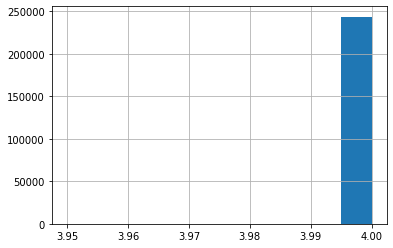

In [52]:
dfPredicted = pd.DataFrame({"Predict": test_predicted})
dfPredicted['Predict'].hist(bins=10)


In [53]:
mae = mean_absolute_error(dfValiTarget, test_predicted)

print("Average MAE: " + str(mae))
print("analyse_maes.append(" + str(mae) + ")")

Average MAE: 0.49472776561103043
analyse_maes.append(0.49472776561103043)


Write to a subrun file

In [54]:
dfPredicted = pd.concat([dfValiIds.reset_index(), dfPredicted], axis=1).drop(columns="index")

if writeSubRunFile:
  dfPredicted.to_csv(subrunDir + filePrefix + "_subrun.csv", index=False)

print("Average MAE: " + str(mae))
print(dfPredicted.shape)
dfPredicted.sort_values("RowID").head(20)


Average MAE: 0.49472776561103043
(243834, 4)


,RowID,BeerID,ReviewerID,Predict
0,22,12300,2634,4.0
1,27,12300,5634,4.0
2,28,12300,3544,4.0
3,40,12300,6521,4.0
4,43,12300,10177,4.0
5,48,12300,2907,4.0
6,49,12300,1532,4.0
7,50,12300,3452,4.0
8,59,12300,6861,4.0
9,64,6699,6401,4.0


# Summary

No Param Tuning
* Beer Name NLP, 200k
* MAE 0.4382028648981029

